In [195]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from phase_transition_experiment.sample_survival_poisson import sample_survival_poisson
from twosample import binom_test

In [196]:
def quantile(x, q):
    """
    Compute the q-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

def q95(x):
    return quantile(x, .95)

def q80(x):
    return quantile(x, .8)

### Read Results:

In [197]:
data_null = pd.read_csv("./results/merged.csv").filter(regex = '^((?!Unnamed).)*$')
#data_null = pd.read_csv("./results_-3152.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./results/results_32034.csv").filter(regex = '^((?!Unnamed).)*$')
results = pd.read_csv("./results/merged.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./test.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./results/results_71140.csv").filter(regex = '^((?!Unnamed).)*$')

out_filename = 'fig'
data_null = results
df0 = data_null[data_null.r == 0]
df1 = results

len(df1.r.unique())


23

In [198]:
from scipy.optimize import curve_fit

def fit_sigmoid(xdata, ydata):
    def sigmoid(x, intercept, slope):
        return 1 / (1+np.exp(-slope * (x - intercept)))

    popt, pcov = curve_fit(sigmoid, xdata, ydata, [.5, 1], method="lm")
    return popt


def sigmoid_intercept(xdata, binary_vector):
    """
    Return the intercept of a sigoid fitted to the binary vector
    """
    try:
        return fit_sigmoid(xdata, binary_vector)[0]
    except:
        return np.nan


def rhos(be, sigma=1):
    if sigma**2 < 2:
         ret = (2 - sigma**2) * (be - 1/2) * (be < 1 - sigma**2/4) + (1 - sigma*np.sqrt(1- be))**2 * (be >= 1 - sigma**2/4)
    else:
         ret = (1 - sigma*np.sqrt(1 - be))**2 * (be > 1 - 1/sigma**2)
    return np.maximum(ret, 0)


def compute_power_mat(df, tcrit, level=0.05):
    bb = df['beta'].unique()
    rr = df['r'].unique()
    
    mat = np.zeros((len(bb), len(rr)))
    for i,beta in enumerate(bb):
        for j,r in enumerate(rr):
            dfs = df[(df['beta'] == beta) & (dfc['r'] == r) ]
            nMonte = len(dfs)
            empirical_power = np.mean(dfs['value'] > tcrit)
            binom_pval = binom_test(empirical_power * nMonte,
                                                np.array(nMonte), level, alt='greater')
            mat[i,j] = empirical_power
    return mat

def compute_power(df, tcrit, level=0.05):
    """
    Empirical power of test statistics 'value' at level 'level'
    and binomial P-value of a test for power 
    significantly better than 'level' 
    """
    df_res = pd.DataFrame()
    for i,c in enumerate(df.groupby(['beta', 'r'])):
        nMonte = len(c[1])
        empirical_power = np.mean(c[1]['value'] > tcrit)
        binom_pval = binom_test(empirical_power * nMonte,
                                            np.array(nMonte), level, alt='greater')
        r = pd.DataFrame({'beta' : c[0][0],
                         'r' : c[0][1],
                         'empirical_power': empirical_power,
                         'empirical_power_pval': binom_pval}, index=[i]
                        )
        df_res = pd.concat([df_res, r])
    return df_res


In [199]:
level = .05
global_params = ['T', 'N1', 'N2']
tcrit = df0.groupby(global_params).agg(lambda x : quantile(x, 1-level))
tcrit

,,,job_id,itr,lam0,beta,r,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,berk_jones_less,wilcoxon_less
T,N1,N2,,,,,,,,,,,,,,,,,
1000,10000,10000,NaN,191.0,1.0,0.95,0.0,1.984931,1.560914,1.616963,8.316517,46.051702,2.127506,1.984931,315.942876,3.475454,46.051702,46.051702,2.124222


In [200]:
a = []
value = 'logrank_lifelines_peto'
t = tcrit[value].values[0]

df_res = pd.DataFrame()
for i,c in enumerate(df1.rename(columns={'log_rank_greater' : 'value'}).groupby(['beta', 'r'])):
    nMonte = len(c[1])
    empirical_power = np.mean(c[1]['value'] > t)
    binom_pval = binom_test(empirical_power * nMonte,
                                        np.array(nMonte), level, alt='greater')
    r = pd.DataFrame({'beta' : c[0][0],
                     'r' : c[0][1],
                     'empirical_power': empirical_power,
                     'empirical_power_pval': binom_pval}, index=[i]
                    )
    df_res = pd.concat([df_res, r])


KeyError: 'logrank_lifelines_peto'

In [ ]:
def std_95(x):
    return np.std(x) * np.sqrt(.95 * (1 - .95) / len(x))

def stdn(x):
    return np.std(x) / np.sqrt(len(x))

df0.agg([q95, std_95])

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_2350/3257438021.py:7: FutureWarning: ['job_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df0.agg([q95, std_95])


,job_id,itr,T,N1,N2,lam0,beta,r,log_rank_greater,log_rank_pval_greater,...,log_rank_pval_less,hc_less,fisher_less,min_p_less,berk_jones_less,logrank_lifelines_None,logrank_lifelines_wilcoxon,logrank_lifelines_tarone-ware,logrank_lifelines_peto,logrank_lifelines_fleming-harrington
q95,NaN,190.050000,1000.0,10000.0,10000.0,1.0,0.950000,0.0,1.668704,0.957894,...,0.952412,0.894392,1609.447473,8.285067,46.051702,75.880199,6.585051,10.598823,6.569785,6.568627
std_95,NaN,0.268268,0.0,0.0,0.0,0.0,0.000735,0.0,0.004771,0.001358,...,0.001358,0.006185,0.254393,0.004894,0.014695,201775.376351,0.011696,0.019088,0.011676,0.011673


Analyzing the case (T, N1, N2) = (1000, 10000, 10000)


/Users/kipnisal/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


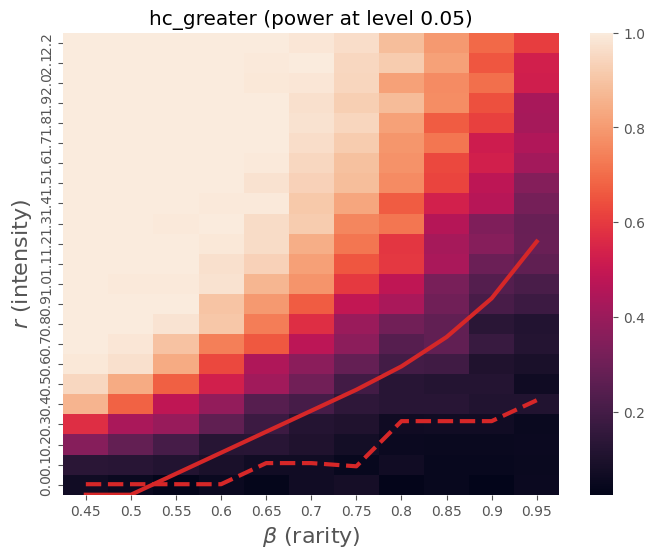

/Users/kipnisal/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


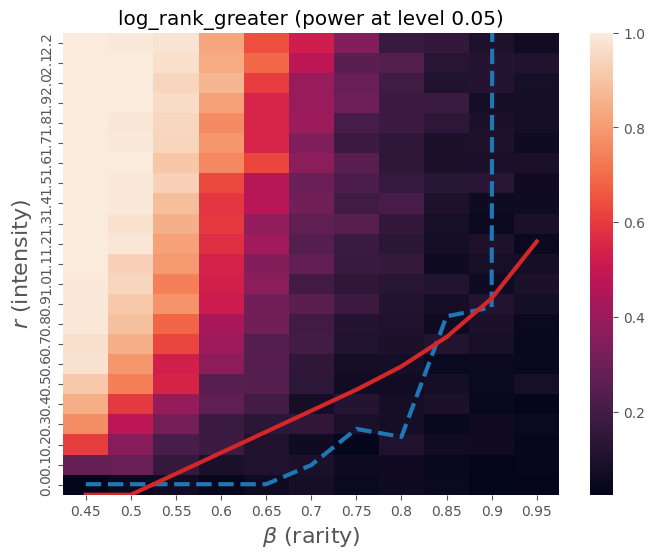

/Users/kipnisal/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


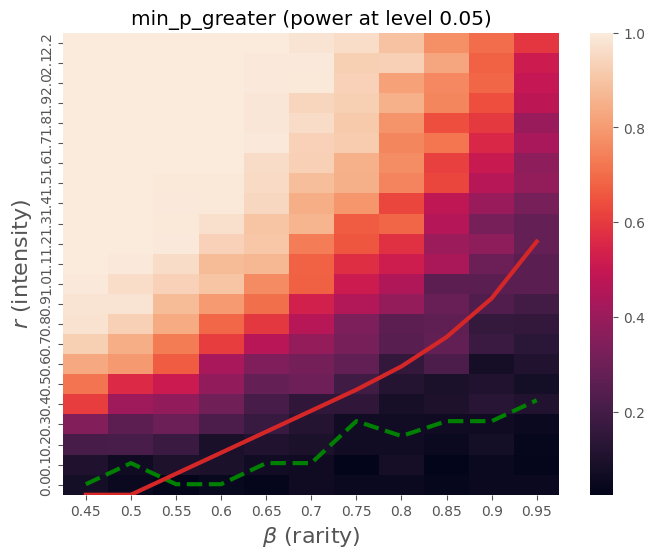

/Users/kipnisal/survival/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


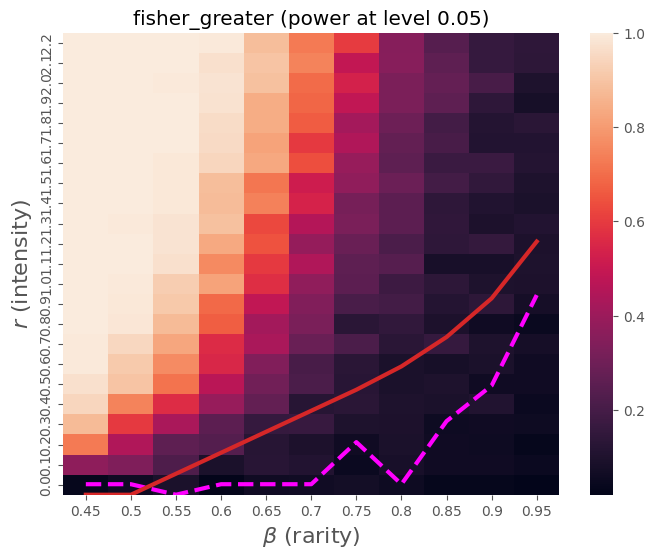

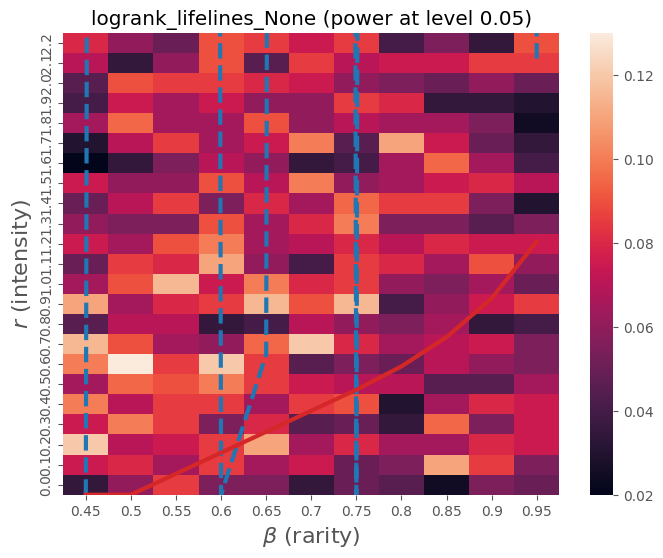

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_2350/401033762.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-slope * (x - intercept)))


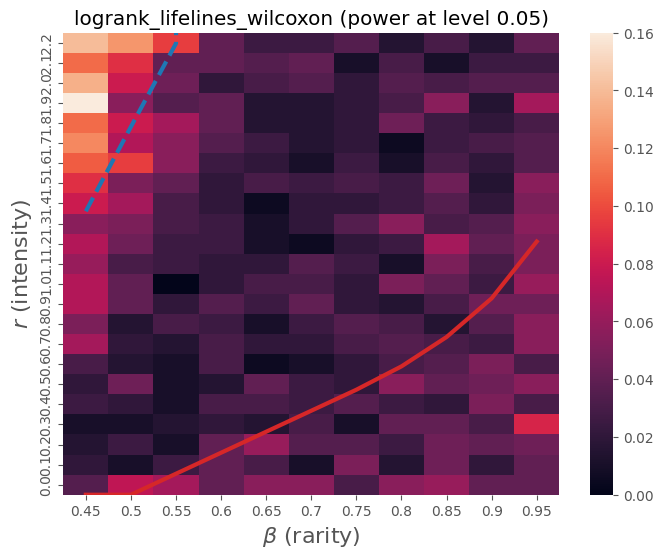

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_2350/401033762.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1+np.exp(-slope * (x - intercept)))


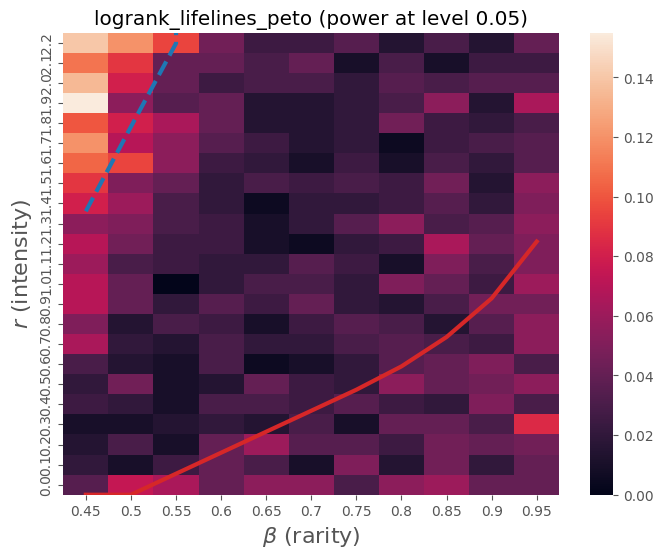

In [ ]:
out_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"
out_dir = ""
out_filename = out_dir + 'phase_diagram_'
#def illustrate_phase_diagrams(df1, df0, out_filename='phase_diagram'):
"""

Args:
-----
:df1:   results from experiments under alternative 
:df0:   results from experiments under null
:out_filename:   file/path name to write to
"""

params = ['itr', 'T', 'N1', 'N2', 'r', 'beta']
tests = ['hc_greater', 'log_rank_greater', 'min_p_greater', 'fisher_greater', 'logrank_lifelines_None',
 'logrank_lifelines_wilcoxon', 'logrank_lifelines_peto'] #, 'min_p', 'berk_jones', 'wilcoxon', 'fisher']
tests_vars = [c for c in df0.columns if c not in params and 'Unnamed' not in c]

global_params = ['T', 'N1', 'N2']
level = 0.05
tcrit = df0.groupby(global_params).agg(lambda x : quantile(x, 1-level))

level_bin = 0.05

good_side = 'greater'
bad_side = 'less'


colors = {'hc_greater': '#d62728', 'log_rank_greater': '#1f77b4', 'min_p_greater': 'green',
 'fisher_greater': 'magenta',
 'logrank_lifelines_None': '#1f77b4',
 'logrank_lifelines_wilcoxon': '#1f77b4',
'logrank_lifelines_peto': '#1f77b4'
 }

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]
    nMonte = dfc['itr'].max()

    for tsn in tests:
        # we check rate when both sides succedds. These are not good outcomes
        bb = dfc['beta'].unique()
        rr = dfc['r'].unique()
        
        def r2grid(r):
            return len(rr) / (rr.max() - rr.min()) * (rr.max() - r)
        
        def b2grid(b):
            return len(bb) / (bb.max() - bb.min()) * (b - bb.min())
        
        
        rcrit = np.zeros_like(bb)
        bcrit = np.zeros_like(rr)
        
        mat = compute_power_mat(dfc.rename(columns={tsn : 'value'}), tcrit[tsn].values[0])
                   
        for j,r in enumerate(rr):
            empirical_power = mat[:,j]
            binom_pvals = binom_test(empirical_power * nMonte,
                                    np.array(nMonte), level, alt='greater')
            substentiality_indicator_beta = binom_pvals < level_bin
            bc = sigmoid_intercept(bb, substentiality_indicator_beta)
            bcrit[j] = np.minimum(np.maximum(bc, 0.55), 1)
            
        for i,beta in enumerate(bb):
            empirical_power = mat[i,:]
            binom_pvals = binom_test(empirical_power * nMonte,
                                    np.array(nMonte), level, alt='greater')
            substentiality_indicator_r = binom_pvals < level_bin
            if substentiality_indicator_r[-1] == False:
                rcrit[i] = 100
            elif np.sum(substentiality_indicator_r) == 0:
                rcrit[i] = 100
            else:
                rc = sigmoid_intercept(rr, substentiality_indicator_r)
                rcrit[i] = np.minimum(np.maximum(rc, 0), 2.3)
            

        plt.figure()
        
        g = seaborn.heatmap(mat[:,::-1].T)
        plt.title(f"{tsn} (power at level {level})")
        g.set_xticklabels(bb)
        g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
        g.set_ylabel(r'$r$ (intensity)', fontsize=16)
        g.set_yticklabels(np.round(rr[::-1],2))
        
        color = colors[tsn]
        g.plot(np.arange(len(bb))+.5, r2grid(rcrit), f'--', color=color, linewidth=3, alpha = 1)
        #g.plot(b2grid(bcrit[::-1])+ .5, np.arange(len(rr)), '--b', linewidth=2, alpha = .9)        
        g.plot(np.arange(len(bb))+.5, r2grid(2*rhos(bb)), color='tab:red', linewidth=3, alpha=1)
        
        fn = out_filename + tsn + ".png"
        plt.savefig(fn)
        plt.show()
        

In [201]:
from matplotlib.colors import LinearSegmentedColormap
myColors = (colors['logrank_lifelines_None'], 'lightgray', colors['hc_greater'])
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))


alt_name = 'logrank_lifelines_peto'
level = 0.05
mat_hc = compute_power_mat(df1.rename(columns={'hc_greater' : 'value'}), tcrit['hc_greater'].values[0], level=level)
mat_alt = compute_power_mat(df1.rename(columns={alt_name : 'value'}), tcrit[alt_name].values[0], level=level)

dmat = (mat_hc - mat_alt)

mat_sig_hc = (dmat * np.sqrt(nMonte) > 2) + 0.
mat_sig_alt = (dmat * np.sqrt(nMonte) < -2) + 0.

mat = mat_sig_hc - mat_sig_alt

#cmap = sns.color_palette("deep", n)
g = seaborn.heatmap(mat[:,::-1].T, cmap=cmap, cbar=False, 
                    linewidths=.1, linecolor='lightgray')

g.set_xticklabels(bb)
g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
g.set_yticklabels(np.round(rr[::-1],2))
g.plot(np.arange(len(bb))+.5, r2grid(2*rhos(bb)), 'r', linewidth=2, alpha=.9)
plt.title(f"Significant power difference (level={level})")

plt.savefig(out_dir + "sig_power_diff_HC.png")

plt.show()


KeyError: 'logrank_lifelines_peto'

In [ ]:
df_logrank = compute_power(df1.rename(columns={'log_rank_greater' : 'value'}), tcrit['log_rank_greater'].values[0], level=level)
df_hc = compute_power(df1.rename(columns={'hc_greater' : 'value'}), tcrit['hc_greater'].values[0], level=level)

df_diff = df_hc.merge(df_logrank, on=['beta', 'r'], suffixes=('_hc', '_lr'))

df_diff.loc[:, 'sig_hc'] = 0. + ((df_diff['empirical_power_hc'] - df_diff['empirical_power_lr']) * np.sqrt(nMonte) > 2)
df_diff.loc[:, 'sig_lr'] = 0. + ((df_diff['empirical_power_lr'] - df_diff['empirical_power_hc']) * np.sqrt(nMonte) > 2)

df_diff.loc[:, 'diff'] = df_diff['sig_hc'] - df_diff['sig_lr']

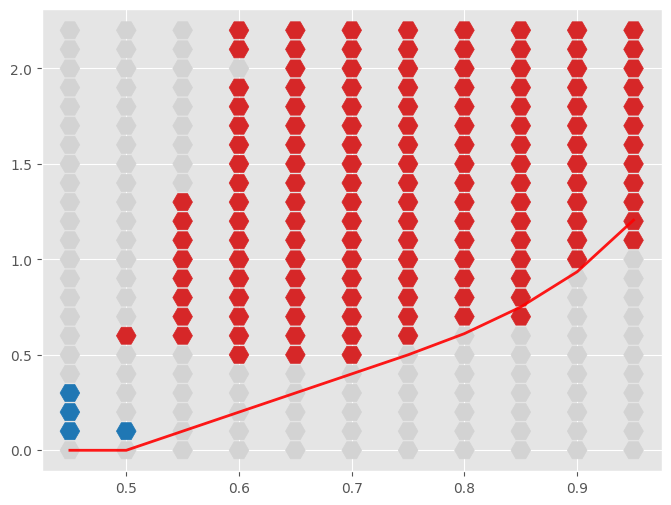

In [ ]:
plt.scatter(df_diff['beta'], df_diff['r'], c = df_diff['diff'], cmap=cmap, s=200, marker='H')
plt.plot(df_diff['beta'], 2*rhos(df_diff['beta']), 'r', linewidth=2, alpha=.9)

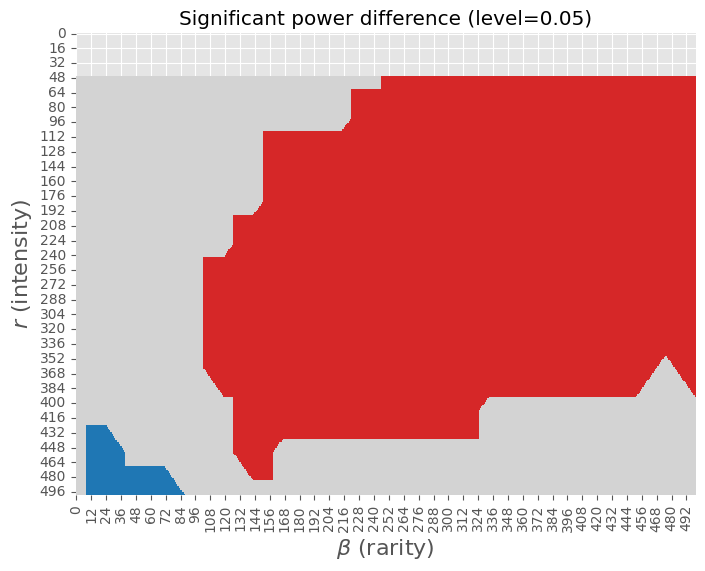

In [ ]:
from scipy.interpolate import griddata
from matplotlib import cm
#determine grid boundaries
gridsize = 500
x_min = 0.45
x_max = 1
y_min = 0
y_max = 2.1

xx = np.linspace(x_min, x_max, gridsize) # array of x values
yy = np.linspace(y_min, y_max, gridsize) # array of y values

grid = np.array(np.meshgrid(xx, yy.T))
grid = grid.reshape(2, grid.shape[1]*grid.shape[2]).T

z_grid2 = griddata(df_diff[['beta', 'r']], df_diff['diff'], grid, method='linear')

z_grid2 = z_grid2.reshape(xx.shape[0], yy.shape[0])

g = seaborn.heatmap(z_grid2[:,::-1].T, cmap=cmap, cbar=False)

g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
plt.title(f"Significant power difference (level={level})")


plt.show()

## Fisher seems to significantly outperform log-rank

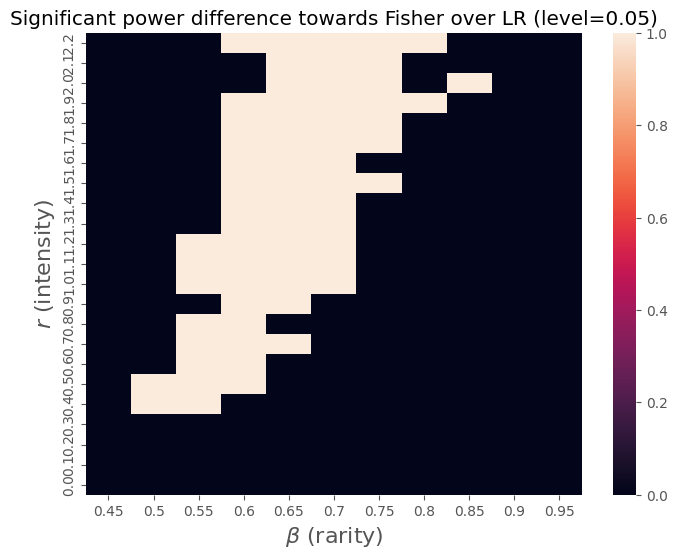

In [ ]:
mat2 = compute_power_mat(df1.rename(columns={'log_rank_greater' : 'value'}), tcrit['log_rank_greater'].values[0], level=level)
mat1 = compute_power_mat(df1.rename(columns={'fisher_greater' : 'value'}), tcrit['fisher_greater'].values[0], level=level)

dmat = (mat1 - mat2)

mat_sig1 = dmat * np.sqrt(nMonte) > 2
mat_sig2 = dmat * np.sqrt(nMonte) < -2

g = seaborn.heatmap(mat_sig1[:,::-1].T)

g.set_xticklabels(bb)
g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
g.set_yticklabels(np.round(rr[::-1],2))
plt.title(f"Significant power difference towards Fisher over LR (level={level})")
plt.savefig(out_dir + "sig_power_diff_fisher_LR.png")
plt.show()




## Check phase transition curves
For verifying theoretic result and comparing balanced vs. non-balanced

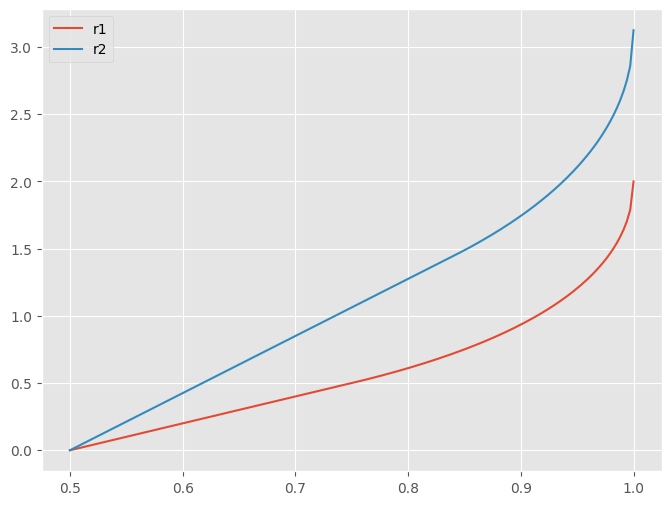

In [70]:
bb = np.linspace(0.5, 1, 171)

def rhos(be, sigma):
    if sigma**2 < 2:
        if be < 1 - sigma**2/4:
            return (2-sigma**2) * (be - 1/2)
        else:
            return (1-sigma*np.sqrt(1- be))**2
    else:
        if be < 1 - 1/sigma**2:
            return 0
        else:
            return (1-sigma*np.sqrt(1- be))**2

        
def plot_PT(r, sig):
    bb = np.linspace(0.5, 1, 171)
    rr = [rhos(b, sig) / r for b in bb]
    plt.plot(bb, rr)

            
kappa = 1/5

kappa_bar = 1 - kappa

r1 = 1 / 2
sig1 = 1

plot_PT(r1, sig1)

r2 = 2 * kappa * kappa_bar
sig2 = np.sqrt(4 * kappa * kappa_bar)

plot_PT(r2, sig2)

plt.legend(['r1', 'r2'])
plt.show()

## Evaluate 

In [94]:
from survival import evaluate_rare_and_weak, _evaluate_test_stats, logrank_lifeline_survival_table

In [212]:

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, **kwargs):
    """
    Evaluate many tests for comparing the lists Nt1 and Nt2

    Args:
    :Nt1: first list of at_risk subjects
    :Nt2: second list of at_risk subjects
    :Ot1: number of events in group 1
    :Ot2: number of events in group 2


    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    """

    randomize = kwargs.get('randomize', False)
    alternative = kwargs.get('alternative', 'both')  # 'both' != 'two-sided'
    stbl = kwargs.get('stbl', True)
    discard_ones = kwargs.get('discard_ones', True)  # ignore P-values that are one


    if alternative == 'both':
        r_greater = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='greater',
                                         stbl=stbl, randomize=randomize, 
                                         discard_ones=discard_ones)
        r_less = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='less',
                                      stbl=stbl, randomize=randomize,
                                        discard_ones=discard_ones)

        res = dict([(k + '_greater', r_greater[k]) for k in r_greater.keys()]
                    + [(k + '_less', r_less[k]) for k in r_less.keys()]
                    )
    else:
        r = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative=alternative,
                                 stbl=stbl, randomize=randomize, discard_ones=discard_ones)
        res = dict([(k + '_' + alternative, r[k]) for k in r.keys()])


    Nt1 = np.concatenate([Nt1, [Nt1[-1]-Ot1[-1]]], axis=0)
    Nt2 = np.concatenate([Nt2, [Nt2[-1]-Ot2[-1]]], axis=0)
    Ct1 = (-np.diff(Nt1) - Ot1).astype(int)
    Ct2 = (-np.diff(Nt2) - Ot2).astype(int)

    print(Ct2)
    assert np.abs(Ct2).sum() == 0
    assert np.abs(Ct1).sum() == 0

    dfg = pd.DataFrame({'observed:0' : Ot1, 'observed:1': Ot2, 'censored:0': Ct1, 'censored:1': Ct2})
    weightings = [None, 'wilcoxon', 'tarone-ware', 'peto', 'fleming-harrington10', 'fleming-harrington01']
    for wt in weightings:
        if wt == 'fleming-harrington10':
            res[f'logrank_lifelines_{wt}'] = logrank_lifeline_survival_table(dfg, weightings='fleming-harrington', p=1, q=0).test_statistic
        elif wt == 'fleming-harrington01':
            res[f'logrank_lifelines_{wt}'] = logrank_lifeline_survival_table(dfg, weightings='fleming-harrington', p=0, q=1).test_statistic
        else:
            res[f'logrank_lifelines_{wt}'] = logrank_lifeline_survival_table(dfg, weightings=wt).test_statistic

    return res


In [213]:
STBL = True
T = 1000
N2 = N1 = 100
lam0 = 1
beta = .75
r = 2

eps = T ** (-beta)
lam = lam0 * np.ones(T) / T

Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, eps, r)
Ot1 = -np.diff(Nt1).astype(int)
Ot2 = -np.diff(Nt2).astype(int)
res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                            randomized=True, alternative='both', stbl=STBL)
res

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

AssertionError: 

In [223]:
Nt10 = Nt1[:-1]
Nt20 = Nt2[:-1]
Nt1 = np.concatenate([Nt10, [Nt10[-1]-Ot1[-1]]], axis=0)
Nt2 = np.concatenate([Nt20, [Nt20[-1]-Ot2[-1]]], axis=0)
Ct1 = (-np.diff(Nt10) - Ot1).astype(int)
Ct2 = (-np.diff(Nt20) - Ot2).astype(int)

In [224]:
Nt2

array([100., 100., 100., ...,  26.,  26.,  26.])

In [167]:
from lifelines.statistics import logrank_test